# Evaluating Denoising Efficiency

## Introduction 

Simulated using MIRT as described in [Nelson et al., 2023](https://onlinelibrary.wiley.com/doi/abs/10.1002/mp.16901) where the acquisition parameters are meant to simulate the Siemens Somatom Definition AS+, which is one of the scanners used in developing the [Low Dose CT Grand Challenge Dataset](https://aapm.onlinelibrary.wiley.com/doi/full/10.1002/mp.12345). However I still need to be careful that this is an approximation and there still may be mismatch between the real and simulated scans, though [Zeng et al., 2022](http://onlinelibrary.wiley.com/doi/abs/10.1002/mp.15430) validated the simulations with physical scans based on MTF and NPS performance measures.

**Question**: Data augmentation is a common approach for dealing with limited datasets. Can data augmentation techniques be used to make up for limited pediatric data?

**Hypothesis**: Noise textures from pediatric-sized phantom scans can be used as an effective data augmentation to improve denoising model generalizability to pediatric patients.

*Purpose* to test our hypothesis that training with noise augmentation can improve performance in pediatric patients. This notebook presents the results in terms of denoising efficiency, which we define in two ways depending on the data available.

If we assume noise as additive ([double check this assumption](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.poisson.html#numpy.random.Generator.poisson)) then we can say the measured signal is $y=Ax + n$, where $x$ is the map of x-ray attenuation coefficients in the cross-section and $y$ is the measured x-ray projections with added blurring and artifacts from the system matrix $A$ and noise $n$. Image reconstruction then takes the form of $x' = A^{-1}(y - n) ~ A^{-1}y - A^{-1}n$ Thus the idea of image-based denoising assumes that the noise in the CT image is seperable and can be estimated and subtracted  

## Methods: Measures of Noise Reduction
To evaluate the estimation of x' we can define RMSE as a measure of how well we've estimated and thus removed noise from the image.

$$
\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^N (x'_i - x_i)^2}
$$



Key to RMSE is assumed knowledge of the ground truth image $x$, which we have access to in simulations. However when we using patient images we don't have access to ground truth, at best we have a low dose and routine dose pair to compare a against to get MSE.

If even that doesn't exist you can select a region that is assumed to be uniform and compare measured standard deviation $\sigma$ in the region:

$$
\sigma = \sqrt{\frac{1}{N} \sum_{i=1}^N (x_i' - \mu)^2},\text{ where } \mu = \frac{1}{N} \sum_{i=1}^N x'_i
$$

here we assume a uniform region such that that $\bar{x}$ is assumed to be the true value for an unbiased measurement in a uniform region

We can thus define noise reduction both in terms of noise std and RMSE as:

$$
\text{Noise Reduction} = 100\% \times \frac{(\text{FBP} - \text{denoised})}{\text{FBP}}
$$

Defining noise reduction relative to the original FBP noise level

## Outline
- [Noise Reduction in Uniform Phantoms](#Noise-Reduction-in-Uniform-Phantoms)
- [Noise Reduction in Anthropomorphic Phantoms](#Noise-Reduction-in-Anthropomorphic-Phantoms)
- [Putting it all together: denoising trends with phantom size](#Putting-it-all-together:-plotting-trends)
- [Conclusions](#Conclusions)

Focus is on noise magnitude reduction in uniform phantoms and low dose patient images and RMSE reduction in uniform and anthropomorphic phantoms since ground truth is known.

## Noise Reduction in Uniform Phantoms

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import SimpleITK as sitk

import sys
sys.path.append('..')

from utils import circle_select, get_circle_diameter, load_mhd, ctshow, make_montage, add_random_circle_lesion, get_ground_truth, measure_roi_std_results, measure_rmse_results

base_dir = Path('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation')
phantom_dir = base_dir / 'CCT189_peds'
anthro_dir = base_dir / 'anthropomorphic'

In [2]:
phantom_meta = pd.read_csv(phantom_dir / 'metadata.csv')
phantom_meta.file = phantom_meta.file.apply(lambda o: str(phantom_dir / o))
anthro_meta = pd.read_csv(anthro_dir / 'metadata.csv')
anthro_meta.file = anthro_meta.file.apply(lambda o: anthro_dir / o)
meta = pd.concat([anthro_meta, phantom_meta], ignore_index=True)
meta

Code #             Name  age (year) gender  weight (kg)  \
0    Reference newborn      male infant       0.166      M          3.8   
1    Reference newborn      male infant       0.166      M          3.8   
2    Reference newborn      male infant       0.166      M          3.8   
3    Reference newborn      male infant       0.166      M          3.8   
4    Reference newborn      male infant       0.166      M          3.8   
..                 ...              ...         ...    ...          ...   
793                NaN  15.1 cm uniform         NaN    NaN          NaN   
794                NaN  15.1 cm uniform         NaN    NaN          NaN   
795                NaN  15.1 cm uniform         NaN    NaN          NaN   
796                NaN  15.1 cm uniform         NaN    NaN          NaN   
797                NaN  15.1 cm uniform         NaN    NaN          NaN   

     height (cm)   BMI  weight percentile ethnicity  effective diameter (cm)  \
0           52.0  14.1               36.0       NaN                     11.1   
1           52.0  14.1               36.0       NaN                     11.1   
2           52.0  14.1               36.0       NaN                     11.1   
3           52.0  14.1               36.0       NaN                     11.1   
4           52.0  14.1               36.0       NaN                     11.1   
..           ...   ...                ...       ...                      ...   
793          NaN   NaN                NaN       NaN                     15.1   
794          NaN   NaN                NaN       NaN                     15.1   
795          NaN   NaN                NaN       NaN                     15.1   
796          NaN   NaN                NaN       NaN                     15.1   
797          NaN   NaN                NaN       NaN                     15.1   

     Dose [%]              recon          phantom  \
0          10  RED-CNN augmented  anthropomorphic   
1          10            RED-CNN  anthropomorphic   
2          10                fbp  anthropomorphic   
3          40  RED-CNN augmented  anthropomorphic   
4          40            RED-CNN  anthropomorphic   
..        ...                ...              ...   
793        70            RED-CNN          uniform   
794        70                fbp          uniform   
795        85  RED-CNN augmented          uniform   
796        85            RED-CNN          uniform   
797        85                fbp          uniform   

                                                  file  
0    /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
1    /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
2    /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
3    /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
4    /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
..                                                 ...  
793  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
794  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
795  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
796  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
797  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  

[798 rows x 14 columns]

%pip install -q ipywidgets

In [3]:
from ipywidgets import interact

In [4]:
def browse_studies(phantom, diameter, dose, recon):
    patient = meta[(meta.phantom==phantom) & (meta['Dose [%]']==dose) & (meta['effective diameter (cm)'] == diameter) & (meta['recon'] == recon)].iloc[0]
    offset = 1000 if patient.recon == 'fbp' else 0
    img = load_mhd(patient.file) - offset
    gt = load_mhd(get_ground_truth(patient.file)) - 1000
    plt.figure(dpi=300)
    print(patient)
    ctshow(np.concatenate([img[1], gt], axis=1))
    plt.title(f"{patient['Dose [%]']}% dose {patient.recon} | ground truth")

In [5]:
interact(browse_studies, phantom=meta.phantom.unique(), dose=sorted(meta['Dose [%]'].unique(), reverse=True), diameter = sorted(meta['effective diameter (cm)'].unique()), recon=meta['recon'].unique())

interactive(children=(Dropdown(description='phantom', options=('anthropomorphic', 'MITA-LCD', 'uniform'), valu…

<function __main__.browse_studies(phantom, diameter, dose, recon)>

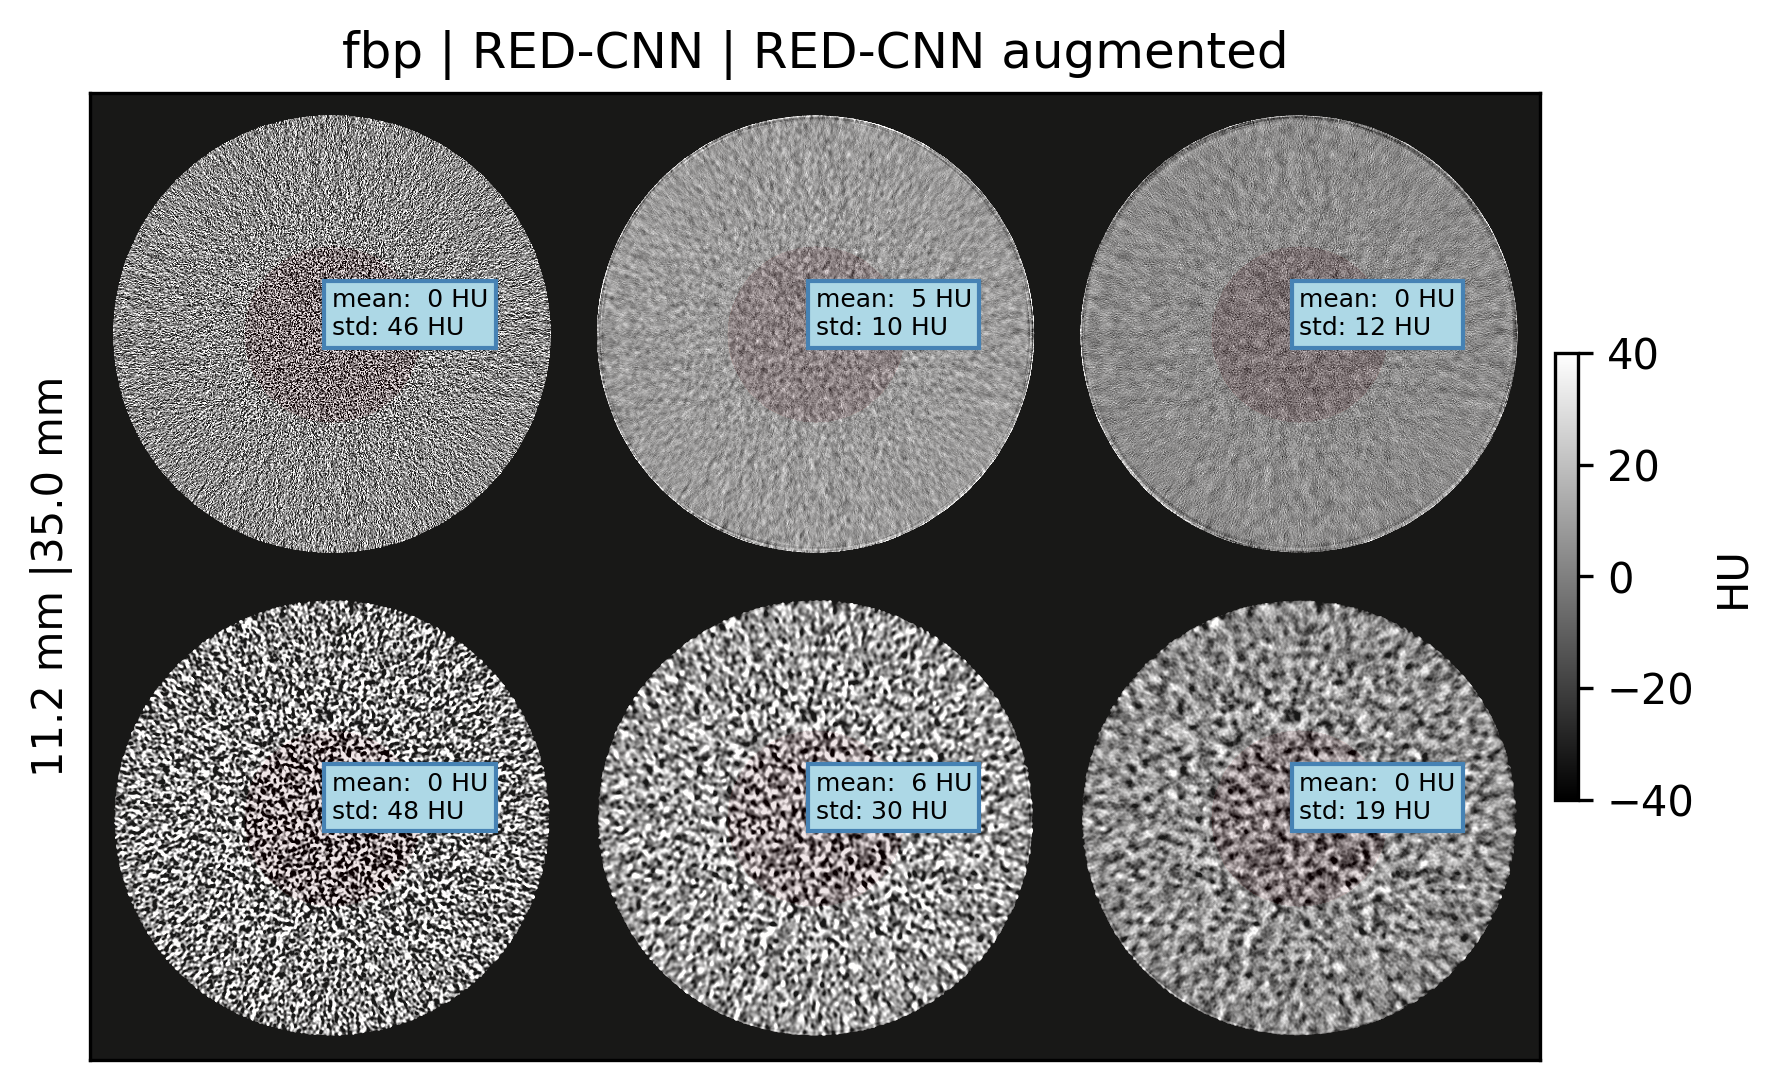

In [6]:
plt.figure(dpi=300)
# @interact use interact for make _montage
make_montage(phantom_meta, phantom='uniform', roi_diameter=0.4)

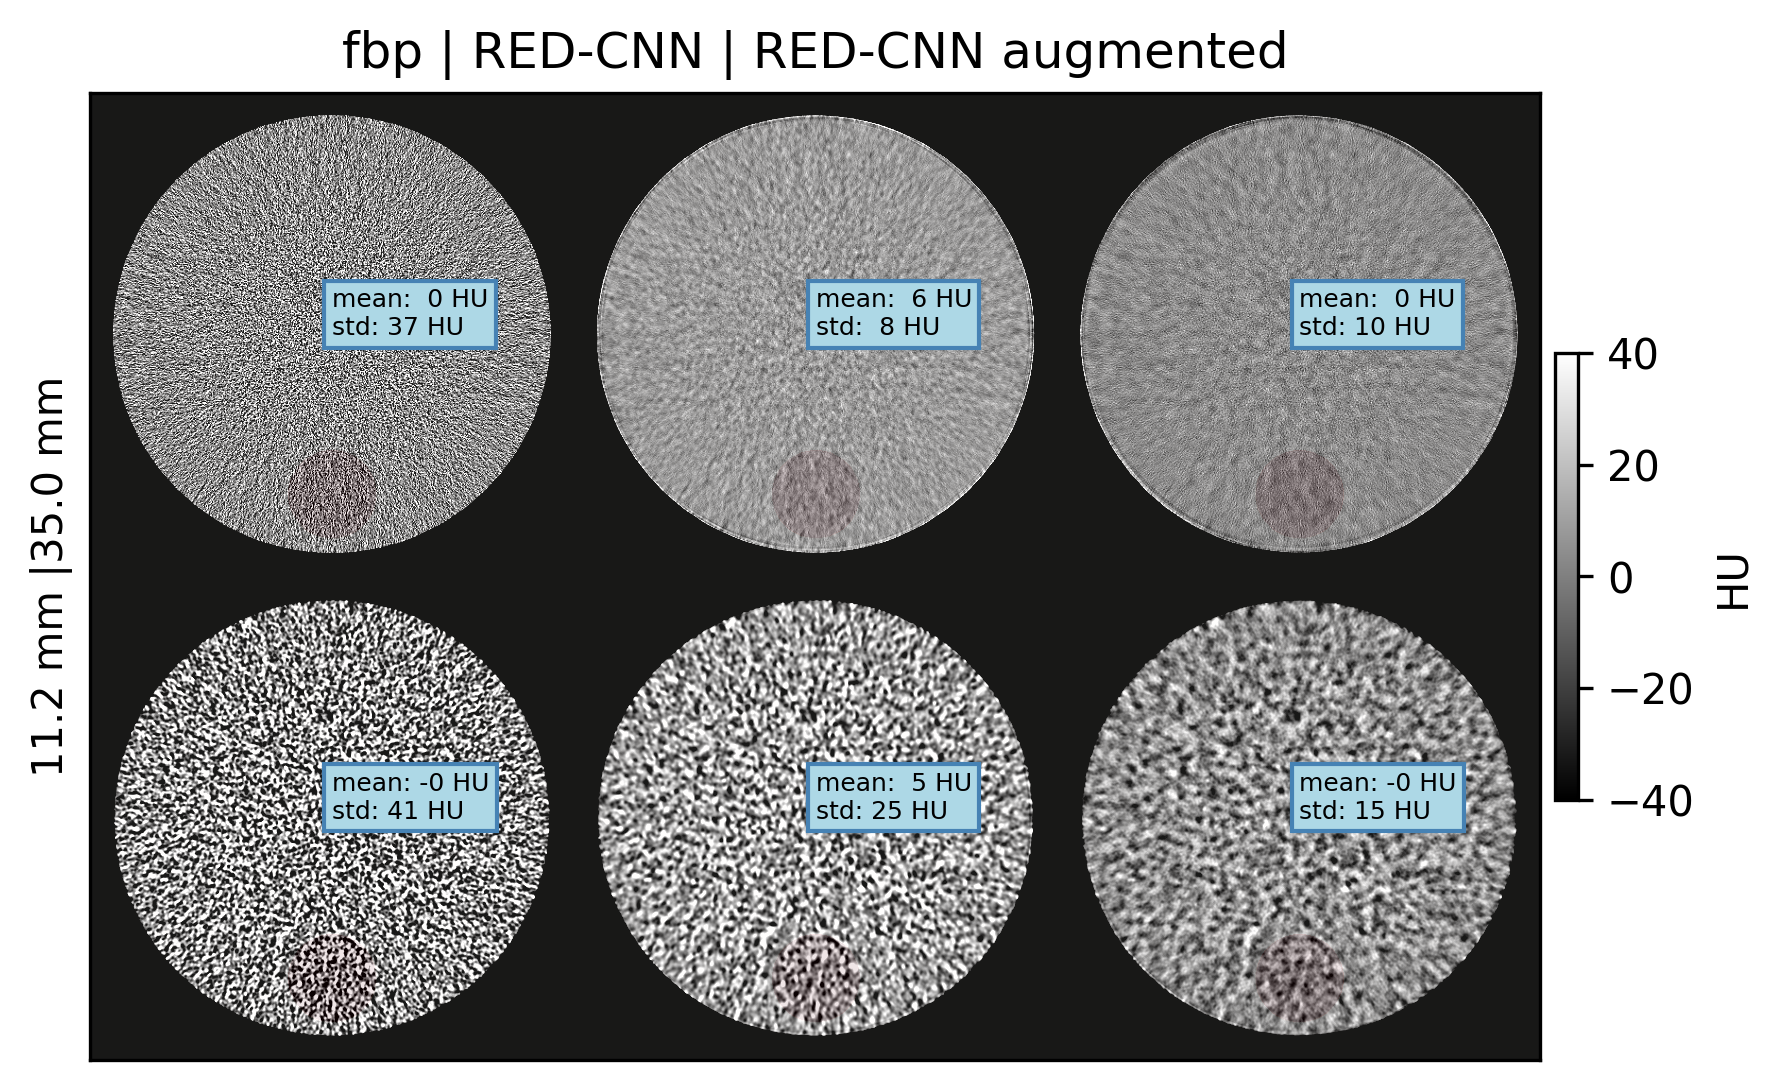

In [7]:
plt.figure(dpi=300)
make_montage(phantom_meta, phantom='uniform', roi_diameter=0.2, roi_center=(425, 256))

### Noise std Reduction in Uniform Phantoms

In [8]:
fbp_qd_350 = load_mhd(phantom_dir / phantom_meta[(phantom_meta.recon == 'fbp') &
                                                 (phantom_meta['effective diameter (cm)'] == 35.0) &
                                                 (phantom_meta['Dose [%]'] == 25) &
                                                 (phantom_meta['phantom']=='uniform')].file.item()).squeeze()[0] - 1000

fbp_qd_112 = load_mhd(phantom_dir / phantom_meta[(phantom_meta.recon == 'fbp') &
                                                 (phantom_meta['effective diameter (cm)'] == 11.2) &
                                                 (phantom_meta['Dose [%]'] == 25) &
                                                 (phantom_meta['phantom']=='uniform')].file.item()).squeeze()[0] - 1000

red_qd_350 = load_mhd(phantom_dir / phantom_meta[(phantom_meta.recon == 'RED-CNN') &
                                                 (phantom_meta['effective diameter (cm)'] == 35.0) &
                                                 (phantom_meta['Dose [%]'] == 25) &
                                                 (phantom_meta['phantom']=='uniform')].file.item()).squeeze()[0] - 0

red_qd_112 = load_mhd(phantom_dir / phantom_meta[(phantom_meta.recon == 'RED-CNN') &
                                                 (phantom_meta['effective diameter (cm)'] == 11.2) &
                                                 (phantom_meta['Dose [%]'] == 25) &
                                                 (phantom_meta['phantom']=='uniform')].file.item()).squeeze()[0] - 0

redaug_qd_350 = load_mhd(phantom_dir / phantom_meta[(phantom_meta.recon == 'RED-CNN augmented') &
                                                    (phantom_meta['effective diameter (cm)'] == 35.0) &
                                                    (phantom_meta['Dose [%]'] == 25) &
                                                    (phantom_meta['phantom']=='uniform')].file.item()).squeeze()[0] - 0

redaug_qd_112 = load_mhd(phantom_dir / phantom_meta[(phantom_meta.recon == 'RED-CNN augmented') &
                                                    (phantom_meta['effective diameter (cm)'] == 11.2) &
                                                    (phantom_meta['Dose [%]'] == 25) &
                                                    (phantom_meta['phantom']=='uniform')].file.item()).squeeze()[0] - 0

phantom_diameter_px = get_circle_diameter(fbp_qd_350)
circle_selection_diameter_px = 0.4*phantom_diameter_px # iec standard suggests centred circle ROI 40% of phantom diameter 
circle_selection = circle_select(fbp_qd_350, xy=(256, 256), r = circle_selection_diameter_px/2)

In [10]:
# from itkwidgets import view
# view(fbp_qd_350)

In [11]:
from utils import noise_reduction

print(f'Large diameter denoising efficiency [RED-CNN]: %{noise_reduction(fbp_qd_350[circle_selection].std(), red_qd_350[circle_selection].std()):2.2f}')
print(f'Small diameter denoising efficiency [RED-CNN]: %{noise_reduction(fbp_qd_112[circle_selection].std(), red_qd_112[circle_selection].std()):2.2f}')
print('---------------------------------------------------------------')
print(f'Large diameter denoising efficiency [RED-CNN Augmented]: %{noise_reduction(fbp_qd_350[circle_selection].std(), redaug_qd_350[circle_selection].std()):2.2f}')
print(f'Small diameter denoising efficiency [RED-CNN Augmented]: %{noise_reduction(fbp_qd_112[circle_selection].std(), redaug_qd_112[circle_selection].std()):2.2f}')

Large diameter denoising efficiency [RED-CNN]: %78.29
Small diameter denoising efficiency [RED-CNN]: %36.74
---------------------------------------------------------------
Large diameter denoising efficiency [RED-CNN Augmented]: %73.19
Small diameter denoising efficiency [RED-CNN Augmented]: %60.09


Looks like augmentation lead to better denoising efficiency in the smaller phantom! ^^ [denoised std/fbp std] --> **[30 HU/48 HU] for REDCNN, compared to [19 HU/48 HU] for augmented!**


**a class would be useful for storing image info and results too..**, mostly for holding the ground truth image and having methods to do different measurements and add them

In [12]:
phantom_meta

Name  effective diameter (cm)  Dose [%]              recon  \
0    35.0 cm MITA-LCD                     35.0        10  RED-CNN augmented   
1    35.0 cm MITA-LCD                     35.0        10            RED-CNN   
2    35.0 cm MITA-LCD                     35.0        10                fbp   
3    35.0 cm MITA-LCD                     35.0        40  RED-CNN augmented   
4    35.0 cm MITA-LCD                     35.0        40            RED-CNN   
..                ...                      ...       ...                ...   
373   15.1 cm uniform                     15.1        70            RED-CNN   
374   15.1 cm uniform                     15.1        70                fbp   
375   15.1 cm uniform                     15.1        85  RED-CNN augmented   
376   15.1 cm uniform                     15.1        85            RED-CNN   
377   15.1 cm uniform                     15.1        85                fbp   

      phantom                                               file  
0    MITA-LCD  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
1    MITA-LCD  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
2    MITA-LCD  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
3    MITA-LCD  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
4    MITA-LCD  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
..        ...                                                ...  
373   uniform  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
374   uniform  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
375   uniform  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
376   uniform  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
377   uniform  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  

[378 rows x 6 columns]

In [13]:
from utils import measure_roi_std_results, calculate_noise_reduction
results_csv = Path('results.csv')

overwrite_results = True

if results_csv.exists() and not overwrite_results:
    results = pd.read_csv(results_csv)
else:
    results = measure_roi_std_results(phantom_meta)
    results = calculate_noise_reduction(results, 'noise std')
results

0 / 378
37 / 378
74 / 378
111 / 378
148 / 378
185 / 378
222 / 378
259 / 378
296 / 378
333 / 378
370 / 378


Name effective diameter (cm) Dose [%]              recon  \
0      35.0 cm MITA-LCD                    35.0       10  RED-CNN augmented   
1      35.0 cm MITA-LCD                    35.0       10  RED-CNN augmented   
2      35.0 cm MITA-LCD                    35.0       10  RED-CNN augmented   
3      35.0 cm MITA-LCD                    35.0       10  RED-CNN augmented   
4      35.0 cm MITA-LCD                    35.0       10  RED-CNN augmented   
...                 ...                     ...      ...                ...   
75595   15.1 cm uniform                    15.1       85                fbp   
75596   15.1 cm uniform                    15.1       85                fbp   
75597   15.1 cm uniform                    15.1       85                fbp   
75598   15.1 cm uniform                    15.1       85                fbp   
75599   15.1 cm uniform                    15.1       85                fbp   

        phantom                                               file sim number  \
0      MITA-LCD  /gpfs_projects/brandon.nelson/PediatricCTSizeD...          0   
1      MITA-LCD  /gpfs_projects/brandon.nelson/PediatricCTSizeD...          1   
2      MITA-LCD  /gpfs_projects/brandon.nelson/PediatricCTSizeD...          2   
3      MITA-LCD  /gpfs_projects/brandon.nelson/PediatricCTSizeD...          3   
4      MITA-LCD  /gpfs_projects/brandon.nelson/PediatricCTSizeD...          4   
...         ...                                                ...        ...   
75595   uniform  /gpfs_projects/brandon.nelson/PediatricCTSizeD...        195   
75596   uniform  /gpfs_projects/brandon.nelson/PediatricCTSizeD...        196   
75597   uniform  /gpfs_projects/brandon.nelson/PediatricCTSizeD...        197   
75598   uniform  /gpfs_projects/brandon.nelson/PediatricCTSizeD...        198   
75599   uniform  /gpfs_projects/brandon.nelson/PediatricCTSizeD...        199   

       noise std  noise std reduction [%]  
0      18.704023                74.500308  
1      18.726599                74.469530  
2      18.830959                74.327253  
3      18.895788                74.238870  
4      18.847178                74.305142  
...          ...                      ...  
75595  25.696408                -0.085752  
75596  25.660946                 0.052370  
75597  25.458151                 0.842244  
75598  25.330178                 1.340691  
75599  25.629527                 0.174745  

[75600 rows x 9 columns]

<Axes: xlabel='effective diameter (cm)', ylabel='noise std'>

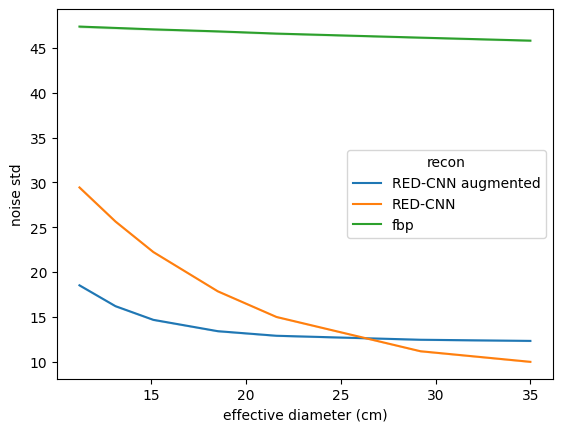

In [14]:
sns.lineplot(data=results[(results['Dose [%]']==25) &
                          (results['effective diameter (cm)'] != 20) &
                          (results.phantom=='uniform')], x='effective diameter (cm)', y='noise std', hue='recon')

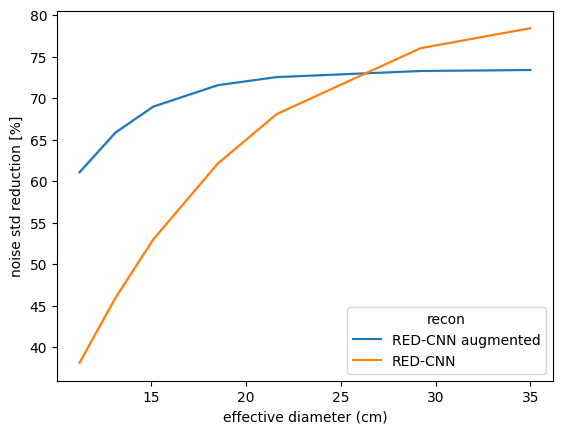

In [44]:
sns.lineplot(data=results[(results['Dose [%]']==25) &
                          (results['effective diameter (cm)'] != 20) &
                          (results.phantom=='uniform') &
                          (results.recon != 'fbp')], x='effective diameter (cm)', y='noise std reduction [%]', hue='recon')
plt.savefig('noise_std_reduction.png', dpi=600)

<Axes: xlabel='effective diameter (cm)', ylabel='noise std reduction [%]'>

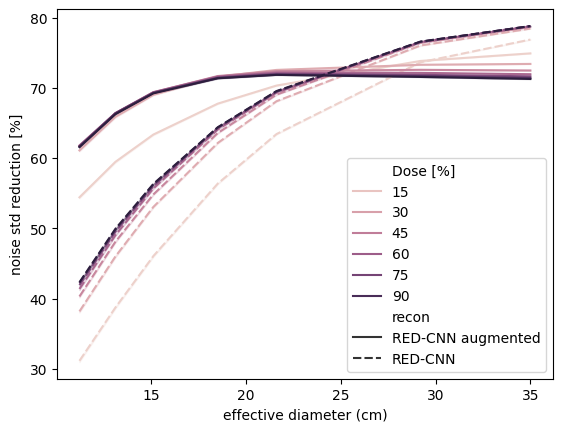

In [16]:
sns.lineplot(data=results[(results['effective diameter (cm)'] != 20) &
                          (results.phantom=='uniform') &
                          (results.recon != 'fbp')], x='effective diameter (cm)', y='noise std reduction [%]', hue='Dose [%]', style='recon')

Looks like the models behave pretty uniformly for dose levels in between quarter dose (25%) and full dose (100%) but for really low doses below the low dose training inputs, such as 15% dose, both RED-CNN and augmented RED-CNN underperform indicated that going for a dose even lower than what was seen during training is also considered out of distribution whereas doses in between training min and max act as in distribution.

### RMSE Reduction in Uniform Phantoms

The original RED-CNN model was most performant on the larger diameter phantom, but noise reduction dropped in the smaller diameter phantom. However, when augmentation is used in training the noise reduction improves in small phantoms! We can expand these measurements to all uniform phantom sizes to get the follow plot and see that our measures above lie on the far extremes of the plot but the trend persists across sizes

In [17]:
phantom_meta

Name  effective diameter (cm)  Dose [%]              recon  \
0    35.0 cm MITA-LCD                     35.0        10  RED-CNN augmented   
1    35.0 cm MITA-LCD                     35.0        10            RED-CNN   
2    35.0 cm MITA-LCD                     35.0        10                fbp   
3    35.0 cm MITA-LCD                     35.0        40  RED-CNN augmented   
4    35.0 cm MITA-LCD                     35.0        40            RED-CNN   
..                ...                      ...       ...                ...   
373   15.1 cm uniform                     15.1        70            RED-CNN   
374   15.1 cm uniform                     15.1        70                fbp   
375   15.1 cm uniform                     15.1        85  RED-CNN augmented   
376   15.1 cm uniform                     15.1        85            RED-CNN   
377   15.1 cm uniform                     15.1        85                fbp   

      phantom                                               file  
0    MITA-LCD  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
1    MITA-LCD  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
2    MITA-LCD  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
3    MITA-LCD  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
4    MITA-LCD  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
..        ...                                                ...  
373   uniform  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
374   uniform  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
375   uniform  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
376   uniform  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
377   uniform  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  

[378 rows x 6 columns]

Name                                                        35.0 cm MITA-LCD
effective diameter (cm)                                                 35.0
Dose [%]                                                                  10
recon                                                      RED-CNN augmented
phantom                                                             MITA-LCD
file                       /gpfs_projects/brandon.nelson/PediatricCTSizeD...
Name: 0, dtype: object


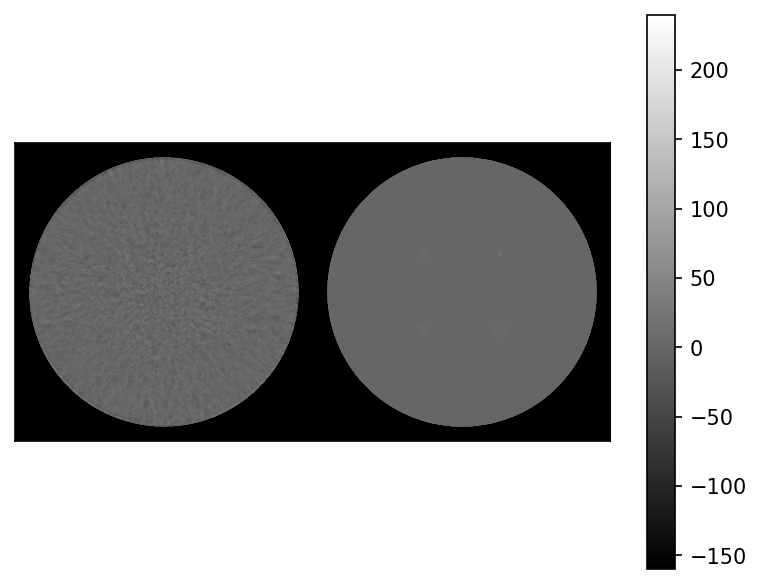

In [18]:
patient = phantom_meta.iloc[0]
offset = 1000 if patient.recon == 'fbp' else 0
img = load_mhd(patient.file) - offset
gt = load_mhd(get_ground_truth(patient.file)) - 1000
print(patient)
plt.figure(dpi=150)
ctshow(np.concatenate([img[1], gt], axis=1))
plt.colorbar()

In [19]:
from utils import measure_rmse_results

In [20]:
results_csv = Path('results.csv')

if results_csv.exists() and not overwrite_results:
    results = pd.read_csv(results_csv)
else:
    rmse_results = measure_rmse_results(phantom_meta)
    results['rmse'] = rmse_results['rmse']
    results = calculate_noise_reduction(results, 'rmse')
results

0 / 378
37 / 378
74 / 378
111 / 378
148 / 378
185 / 378
222 / 378
259 / 378
296 / 378
333 / 378
370 / 378


Name effective diameter (cm) Dose [%]              recon  \
0      35.0 cm MITA-LCD                    35.0       10  RED-CNN augmented   
1      35.0 cm MITA-LCD                    35.0       10  RED-CNN augmented   
2      35.0 cm MITA-LCD                    35.0       10  RED-CNN augmented   
3      35.0 cm MITA-LCD                    35.0       10  RED-CNN augmented   
4      35.0 cm MITA-LCD                    35.0       10  RED-CNN augmented   
...                 ...                     ...      ...                ...   
75595   15.1 cm uniform                    15.1       85                fbp   
75596   15.1 cm uniform                    15.1       85                fbp   
75597   15.1 cm uniform                    15.1       85                fbp   
75598   15.1 cm uniform                    15.1       85                fbp   
75599   15.1 cm uniform                    15.1       85                fbp   

        phantom                                               file sim number  \
0      MITA-LCD  /gpfs_projects/brandon.nelson/PediatricCTSizeD...          0   
1      MITA-LCD  /gpfs_projects/brandon.nelson/PediatricCTSizeD...          1   
2      MITA-LCD  /gpfs_projects/brandon.nelson/PediatricCTSizeD...          2   
3      MITA-LCD  /gpfs_projects/brandon.nelson/PediatricCTSizeD...          3   
4      MITA-LCD  /gpfs_projects/brandon.nelson/PediatricCTSizeD...          4   
...         ...                                                ...        ...   
75595   uniform  /gpfs_projects/brandon.nelson/PediatricCTSizeD...        195   
75596   uniform  /gpfs_projects/brandon.nelson/PediatricCTSizeD...        196   
75597   uniform  /gpfs_projects/brandon.nelson/PediatricCTSizeD...        197   
75598   uniform  /gpfs_projects/brandon.nelson/PediatricCTSizeD...        198   
75599   uniform  /gpfs_projects/brandon.nelson/PediatricCTSizeD...        199   

       noise std  noise std reduction [%]       rmse  rmse reduction [%]  
0      18.704023                74.500308  19.582039           65.279110  
1      18.726599                74.469530  19.625437           65.202161  
2      18.830959                74.327253  19.694382           65.079915  
3      18.895788                74.238870  19.667883           65.126900  
4      18.847178                74.305142  19.693256           65.081910  
...          ...                      ...        ...                 ...  
75595  25.696408                -0.085752  22.589197            0.034552  
75596  25.660946                 0.052370  22.634477           -0.165826  
75597  25.458151                 0.842244  22.604654           -0.033851  
75598  25.330178                 1.340691   22.41049            0.825397  
75599  25.629527                 0.174745  22.631389           -0.152163  

[75600 rows x 11 columns]

<Axes: xlabel='effective diameter (cm)', ylabel='rmse'>

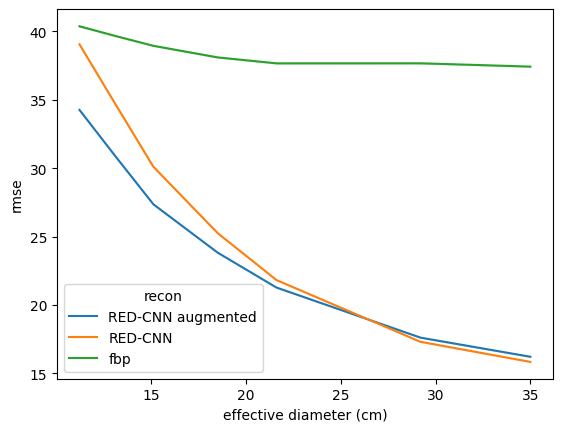

In [21]:
sns.lineplot(data=results[(results['Dose [%]']==25) &
                          (results['effective diameter (cm)'] != 20) &
                          (results.phantom=='uniform')], x='effective diameter (cm)', y='rmse', hue='recon')

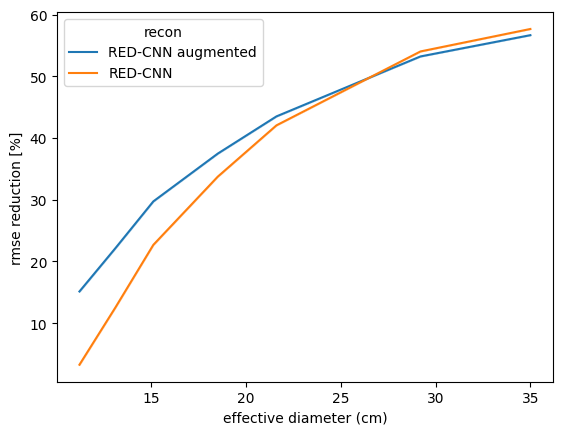

In [45]:
sns.lineplot(data=results[(results['Dose [%]']==25) &
                          (results['effective diameter (cm)'] != 20) &
                          (results.phantom=='uniform') &
                          (results.recon != 'fbp')], x='effective diameter (cm)', y='rmse reduction [%]', hue='recon')
plt.savefig('noise_rmse_reduction.png', dpi=600)

Compared to noise reduction, there isn't as much of a performance gap in adults when measuring RMSE

<Axes: xlabel='effective diameter (cm)', ylabel='rmse'>

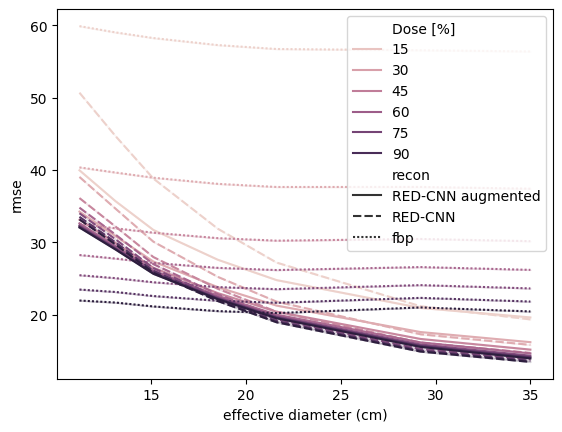

In [23]:
sns.lineplot(data=results[(results['effective diameter (cm)'] != 20) &
                          (results.phantom=='uniform')], x='effective diameter (cm)', y='rmse', hue='Dose [%]', style='recon')

<Axes: xlabel='effective diameter (cm)', ylabel='rmse reduction [%]'>

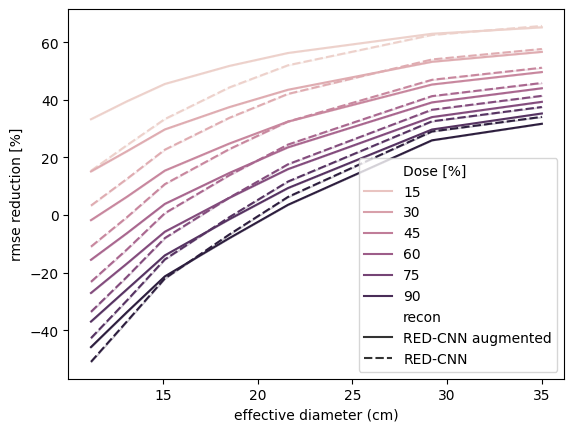

In [24]:
sns.lineplot(data=results[(results['effective diameter (cm)'] != 20) &
                          (results.phantom=='uniform') &
                          (results.recon != 'fbp')], x='effective diameter (cm)', y='rmse reduction [%]', hue='Dose [%]', style='recon')

### Side investigation: comparison of adding noise to training vs adding back part of the fbp image?
**TODO** Need to confirm that training side data augmentation is not inferior to just adding back some noise as done above^

In [25]:
results.head()

Name effective diameter (cm) Dose [%]              recon  \
0  35.0 cm MITA-LCD                    35.0       10  RED-CNN augmented   
1  35.0 cm MITA-LCD                    35.0       10  RED-CNN augmented   
2  35.0 cm MITA-LCD                    35.0       10  RED-CNN augmented   
3  35.0 cm MITA-LCD                    35.0       10  RED-CNN augmented   
4  35.0 cm MITA-LCD                    35.0       10  RED-CNN augmented   

    phantom                                               file sim number  \
0  MITA-LCD  /gpfs_projects/brandon.nelson/PediatricCTSizeD...          0   
1  MITA-LCD  /gpfs_projects/brandon.nelson/PediatricCTSizeD...          1   
2  MITA-LCD  /gpfs_projects/brandon.nelson/PediatricCTSizeD...          2   
3  MITA-LCD  /gpfs_projects/brandon.nelson/PediatricCTSizeD...          3   
4  MITA-LCD  /gpfs_projects/brandon.nelson/PediatricCTSizeD...          4   

   noise std  noise std reduction [%]       rmse  rmse reduction [%]  
0  18.704023                74.500308  19.582039           65.279110  
1  18.726599                74.469530  19.625437           65.202161  
2  18.830959                74.327253  19.694382           65.079915  
3  18.895788                74.238870  19.667883           65.126900  
4  18.847178                74.305142  19.693256           65.081910

In [26]:
redaug_img = load_mhd(results[(results.recon=='RED-CNN augmented') &
                              (results['Dose [%]']==25) &
                              (results['effective diameter (cm)']==35) &
                              (results['phantom'] == 'uniform')].iloc[0].file)

red_img = load_mhd(results[(results.recon=='RED-CNN') &
                           (results['Dose [%]']==25) &
                           (results['effective diameter (cm)']==35) &
                           (results['phantom'] == 'uniform')].iloc[0].file)

fbp_img = load_mhd(results[(results.recon=='fbp') &
                           (results['Dose [%]']==25) &
                           (results['effective diameter (cm)']==35) &
                           (results['phantom'] == 'uniform')].iloc[0].file).astype('float32') - 1000

add_back = red_img + 0.35*(fbp_img - red_img)

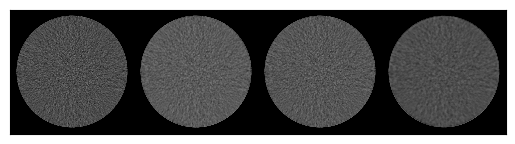

In [27]:
wwwl = (100, 20)
ctshow(np.concatenate([fbp_img[0], red_img[0], add_back[0], redaug_img[0]], axis=1), wwwl)

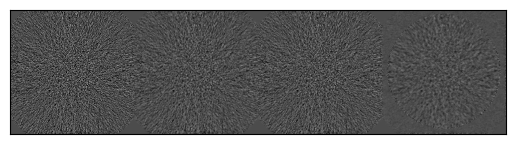

In [28]:
wwwl = (100, 20)
ctshow(np.concatenate([fbp_img[0]-fbp_img[1], red_img[0]-red_img[1], add_back[0]-add_back[1], redaug_img[0]-redaug_img[1]], axis=1), wwwl)

In [29]:
[o.std() for o in [fbp_img[0]-fbp_img[1], red_img[0]-red_img[1], add_back[0]-add_back[1], redaug_img[0]-redaug_img[1]]]

[51.399006, 12.3216505, 24.977684, 14.768357]

## Noise Reduction in Anthropomorphic Phantoms

Because ground truth is known we can evaluate noise removal as root mean squared error (RMSE) reduction.

In [30]:
anthro_meta = pd.read_csv(anthro_dir / 'metadata.csv')
anthro_meta.file = anthro_meta.file.apply(lambda o: anthro_dir / o)
anthro_meta

Code #          Name  age (year) gender  weight (kg)  \
0    Reference newborn   male infant       0.166      M          3.8   
1    Reference newborn   male infant       0.166      M          3.8   
2    Reference newborn   male infant       0.166      M          3.8   
3    Reference newborn   male infant       0.166      M          3.8   
4    Reference newborn   male infant       0.166      M          3.8   
..                 ...           ...         ...    ...          ...   
415                151  female pt151      66.000      F         66.4   
416                151  female pt151      66.000      F         66.4   
417                151  female pt151      66.000      F         66.4   
418                151  female pt151      66.000      F         66.4   
419                151  female pt151      66.000      F         66.4   

     height (cm)        BMI  weight percentile ethnicity  \
0           52.0  14.100000               36.0       NaN   
1           52.0  14.100000               36.0       NaN   
2           52.0  14.100000               36.0       NaN   
3           52.0  14.100000               36.0       NaN   
4           52.0  14.100000               36.0       NaN   
..           ...        ...                ...       ...   
415        162.0  25.301021               48.8     white   
416        162.0  25.301021               48.8     white   
417        162.0  25.301021               48.8     white   
418        162.0  25.301021               48.8     white   
419        162.0  25.301021               48.8     white   

     effective diameter (cm)  Dose [%]              recon          phantom  \
0                       11.1        10  RED-CNN augmented  anthropomorphic   
1                       11.1        10            RED-CNN  anthropomorphic   
2                       11.1        10                fbp  anthropomorphic   
3                       11.1        40  RED-CNN augmented  anthropomorphic   
4                       11.1        40            RED-CNN  anthropomorphic   
..                       ...       ...                ...              ...   
415                     28.1        70            RED-CNN  anthropomorphic   
416                     28.1        70                fbp  anthropomorphic   
417                     28.1        85  RED-CNN augmented  anthropomorphic   
418                     28.1        85            RED-CNN  anthropomorphic   
419                     28.1        85                fbp  anthropomorphic   

                                                  file  
0    /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
1    /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
2    /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
3    /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
4    /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
..                                                 ...  
415  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
416  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
417  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
418  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  
419  /gpfs_projects/brandon.nelson/PediatricCTSizeD...  

[420 rows x 14 columns]

Let's look at a random study of the 420 available... Consder adding [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/user_install.html) - [more examples](https://ipywidgets.readthedocs.io/en/latest/_static/lab/index.html) to make slider bars or selecta boxes to more easily filter and scroll through images

We calculate RMSE by comparing the reconstructed image on the left to the ground truth on the right

In [31]:
if not results_csv.exists() or overwrite_results:
    anthro_results = measure_rmse_results(anthro_meta)
    anthro_results['phantom'] = 'anthropomorphic' # or XCAT
    anthro_results

0 / 420
42 / 420
84 / 420
126 / 420
168 / 420
210 / 420
252 / 420
294 / 420
336 / 420
378 / 420


In [32]:
anthro_results

Code #          Name age (year) gender weight (kg)  \
0     Reference newborn   male infant      0.166      M         3.8   
1     Reference newborn   male infant      0.166      M         3.8   
2     Reference newborn   male infant      0.166      M         3.8   
3     Reference newborn   male infant      0.166      M         3.8   
4     Reference newborn   male infant      0.166      M         3.8   
...                 ...           ...        ...    ...         ...   
4195                151  female pt151       66.0      F        66.4   
4196                151  female pt151       66.0      F        66.4   
4197                151  female pt151       66.0      F        66.4   
4198                151  female pt151       66.0      F        66.4   
4199                151  female pt151       66.0      F        66.4   

     height (cm)        BMI weight percentile ethnicity  \
0           52.0       14.1              36.0       NaN   
1           52.0       14.1              36.0       NaN   
2           52.0       14.1              36.0       NaN   
3           52.0       14.1              36.0       NaN   
4           52.0       14.1              36.0       NaN   
...          ...        ...               ...       ...   
4195       162.0  25.301021              48.8     white   
4196       162.0  25.301021              48.8     white   
4197       162.0  25.301021              48.8     white   
4198       162.0  25.301021              48.8     white   
4199       162.0  25.301021              48.8     white   

     effective diameter (cm) Dose [%]              recon          phantom  \
0                       11.1       10  RED-CNN augmented  anthropomorphic   
1                       11.1       10  RED-CNN augmented  anthropomorphic   
2                       11.1       10  RED-CNN augmented  anthropomorphic   
3                       11.1       10  RED-CNN augmented  anthropomorphic   
4                       11.1       10  RED-CNN augmented  anthropomorphic   
...                      ...      ...                ...              ...   
4195                    28.1       85                fbp  anthropomorphic   
4196                    28.1       85                fbp  anthropomorphic   
4197                    28.1       85                fbp  anthropomorphic   
4198                    28.1       85                fbp  anthropomorphic   
4199                    28.1       85                fbp  anthropomorphic   

                                                   file sim number       rmse  
0     /gpfs_projects/brandon.nelson/PediatricCTSizeD...          0  37.202656  
1     /gpfs_projects/brandon.nelson/PediatricCTSizeD...          1  37.324512  
2     /gpfs_projects/brandon.nelson/PediatricCTSizeD...          2  37.225441  
3     /gpfs_projects/brandon.nelson/PediatricCTSizeD...          3  37.082504  
4     /gpfs_projects/brandon.nelson/PediatricCTSizeD...          4   36.78685  
...                                                 ...        ...        ...  
4195  /gpfs_projects/brandon.nelson/PediatricCTSizeD...          5  29.399138  
4196  /gpfs_projects/brandon.nelson/PediatricCTSizeD...          6  29.340426  
4197  /gpfs_projects/brandon.nelson/PediatricCTSizeD...          7   29.34036  
4198  /gpfs_projects/brandon.nelson/PediatricCTSizeD...          8  29.411117  
4199  /gpfs_projects/brandon.nelson/PediatricCTSizeD...          9  29.364578  

[4200 rows x 16 columns]

### Noise std Reduction in Anthropomorphic Phantoms

Calculating noise reduction using standard deviation ROI measurements is slightly more complicated due to the more heterogenous anthropmorphic phantoms. To ensure we are sampling a uniform region and not a boundary region which will give a high std value but not be indicative of noise, we will use this `add_random_circle_lesion` function which takes as an optional argument a `mask` to specify a domain to place the random roi within. 

In [33]:
from utils import add_random_circle_lesion

In [34]:
add_random_circle_lesion?

Signature: add_random_circle_lesion(image, mask, radius=20, contrast=-100)
Docstring:
Returns tuple of (image with lesion, lesion only image, lesion coordinate (x,y))
:tol: tolerance of fitting lesion into mask, smaller values increases the requirement ensuring more of the circle overlaps with the mask
File:      ~/Dev/PediatricCTSizeAugmentation/notebooks/utils.py
Type:      function

Below we can experiment with some reasonable HU cutoffs to get the liver, note we are doing these thresholds on the ground truth `gt` image so noise is not a factor when getting the mask.

In [35]:
patient = meta[meta['phantom'] == 'anthropomorphic'].iloc[0]
patient

Code #                                                     Reference newborn
Name                                                             male infant
age (year)                                                             0.166
gender                                                                     M
weight (kg)                                                              3.8
height (cm)                                                             52.0
BMI                                                                     14.1
weight percentile                                                       36.0
ethnicity                                                                NaN
effective diameter (cm)                                                 11.1
Dose [%]                                                                  10
recon                                                      RED-CNN augmented
phantom                                                      anthropomorphic

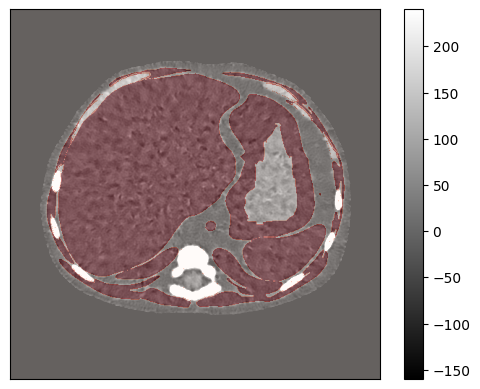

In [36]:
img = load_mhd(patient.file)[0]
gt = load_mhd(get_ground_truth(patient.file)) - 1000
ctshow(img)
plt.colorbar()
mask = (gt >= 50) & (gt < 100)
plt.imshow(mask, alpha=0.4, cmap='Reds') 

By rerunning the cell below multiple times we see the ROI stays in the liver but in different locations each time

Text(0.5, 1.0, 'mean: 62 HU\nstd: 25 HU')

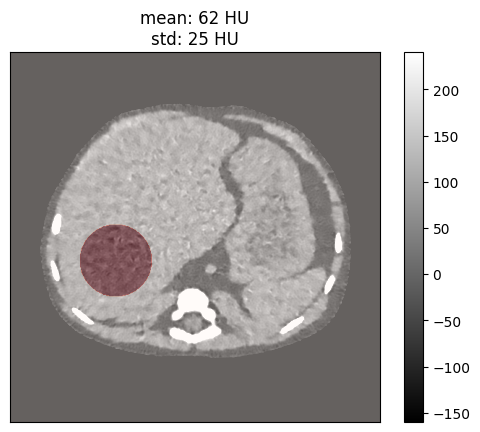

In [37]:
circle_selection = add_random_circle_lesion(img, mask, radius=50)[1].astype(bool)
ctshow(img)
plt.colorbar()
mask = (gt >= 50) & (gt < 100)
plt.imshow(circle_selection, alpha=0.4, cmap='Reds')
plt.title(f'mean: {img[circle_selection].mean():2.0f} HU\nstd: {img[circle_selection].std():2.0f} HU')

This `add_random_circle_lesion` is built into the `make_montage` visualization function to qualitatively compare noise magnitude reduction across reconstruction types, patient size and other parameters

In [38]:
make_montage??

Signature:
make_montage(
    meta_df: pandas.core.frame.DataFrame,
    dose: int = 25,
    diameters: list = [35.0, 11.2],
    recons: list = ['fbp', 'RED-CNN', 'RED-CNN augmented'],
    phantom: str = 'MITA-LCD',
    roi_diameter: float | int = 0.4,
    roi_center: tuple | str = (256, 256),
    wwwl=(80, 0),
)
Source:   
def make_montage(meta_df:pd.DataFrame, dose:int=25, diameters:list=[35.0, 11.2], recons:list = ['fbp', 'RED-CNN', 'RED-CNN augmented'],
                 phantom:str = 'MITA-LCD', roi_diameter:float|int=0.4, roi_center:tuple|str=(256, 256),  wwwl = (80, 0)):
    """
    make image montage based on given argument parameters. Recons are plotted horizontally along the x axis while different diameters are plotted on y
    :Parameters:
        :meta_df: metadata dataframe
        :dose: dose level in percent [%]
        :diameters: phantom effective diameter in cm
        :recons: list of recon kernels to display on the horizontal x-axis
        :phantom: which image phanto

The doc strings describe that rois can be manually placed using a `tuple` as shown below with `roi_center = (x, y)`

Or alternatively an organ can be specified if using an anthropomorphic phantom and an ROI will be randomly place in that ROI, this is useful for the anthropomorphic phantoms because due to size and placement differences between scans the same roi xy coordinates might not always be in the liver

In [39]:
def browse_montage(diameter, recon, **kwargs):
    make_montage(meta_df = meta, roi_center = 'liver', wwwl=(300, 40), diameters=[diameter], recons=[recon], **kwargs)

In [40]:
interact(browse_montage, phantom=meta.phantom.unique(), dose=sorted(meta['Dose [%]'].unique(), reverse=True), diameter = sorted(meta['effective diameter (cm)'].unique()), recon=meta['recon'].unique(), roi_diameter=[0.1, 0.2, 0.3, 0.4, 0.5])

interactive(children=(Dropdown(description='diameter', options=(11.1, 11.2, 13.1, 15.1, 15.4, 16.0, 16.2, 16.3…

<function __main__.browse_montage(diameter, recon, **kwargs)>

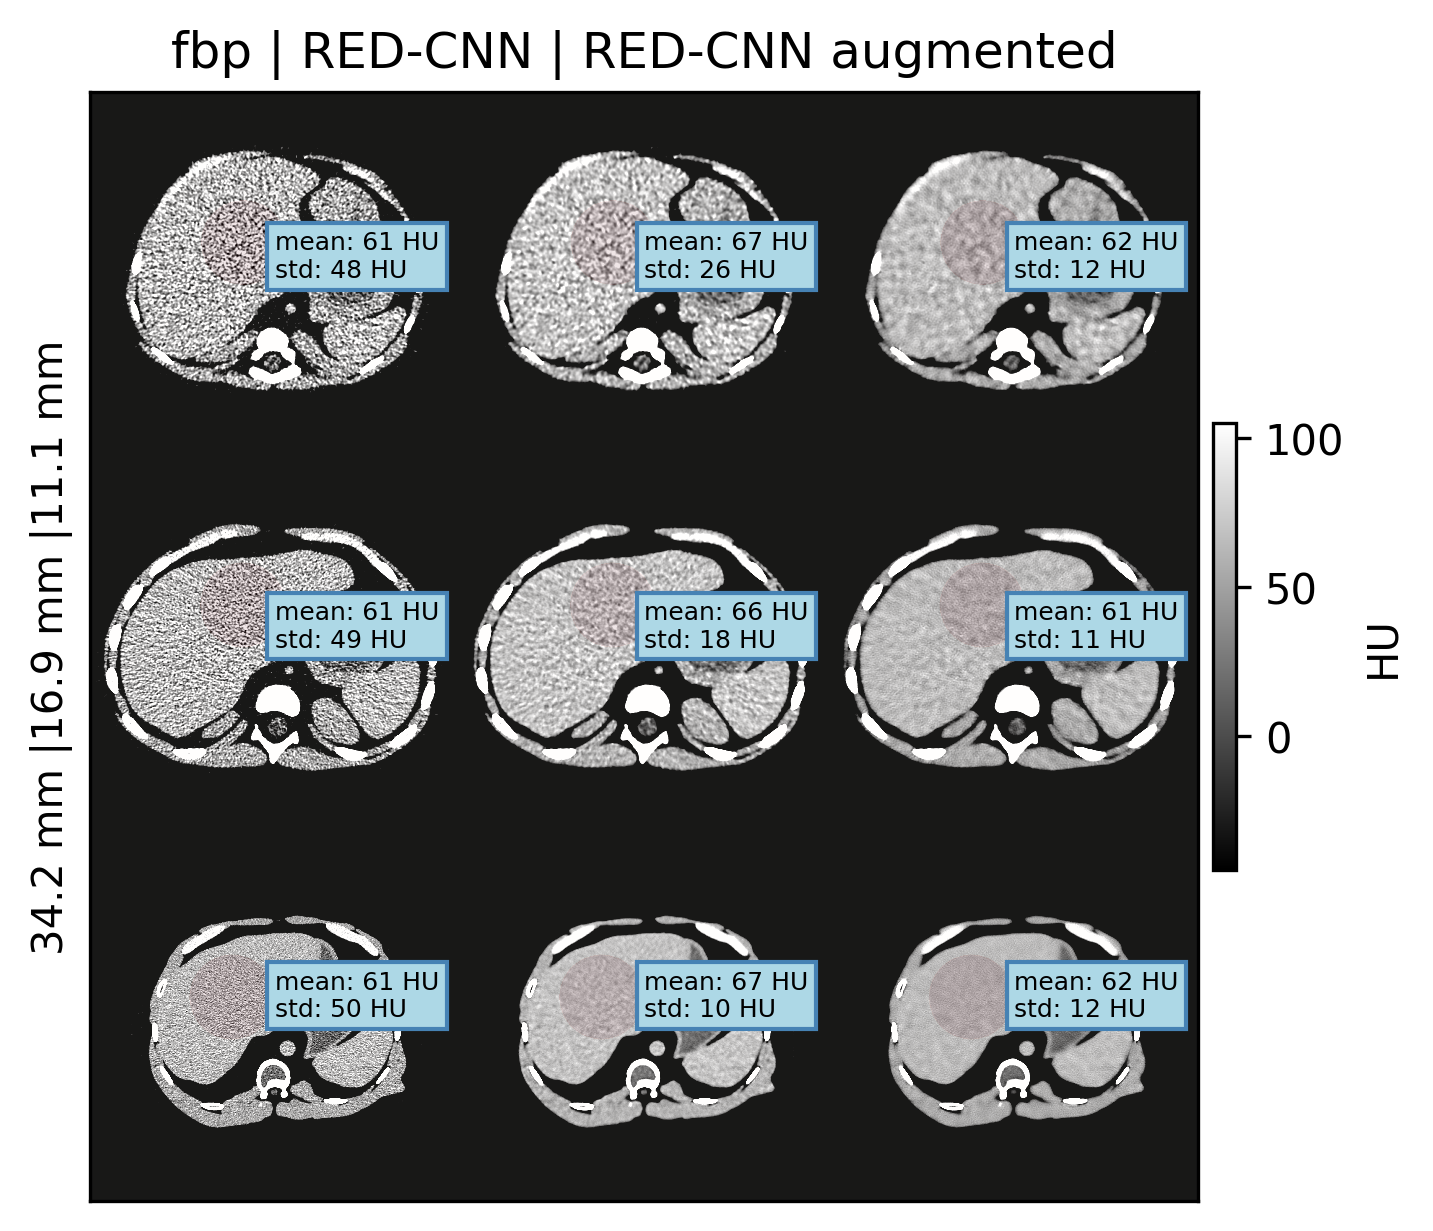

In [41]:
plt.figure(dpi=300)
make_montage(anthro_meta, dose=25, phantom='anthropomorphic', diameters=[11.1, 16.9, 34.2], wwwl=(150, 30), roi_center='liver', roi_diameter=0.25)

In [42]:
from utils import measure_roi_std_results

In [ ]:
if not results_csv.exists() or overwrite_results:
    anthro_std_results = measure_roi_std_results(anthro_meta, roi_diameter=0.2)
    anthro_results['noise std'] = anthro_std_results['noise std']
    anthro_results = calculate_noise_reduction(anthro_results, 'rmse')
    anthro_results = calculate_noise_reduction(anthro_results, 'noise std')
    results = pd.concat([anthro_results, results])
    results.to_csv('results.csv', index=False)
results

This anthropomorphic images are supposed to be around the liver, which is uniform so there should be enough space on each image to sample a large circle roi for noise measures

## Putting it all together: plotting trends

In [ ]:
meta = pd.concat([anthro_meta, phantom_meta], ignore_index=True)
results = measure_rmse_results(meta)
results['noise std'] = measure_roi_std_results(meta)['noise std']
results = calculate_noise_reduction(results, 'rmse')
results = calculate_noise_reduction(results, 'noise std')
results

In [ ]:
results['is adult'] = results['age (year)'] >= 22

In [ ]:
f, axs = plt.subplots(1, 3, dpi=300, sharex=True, sharey=True, figsize=(18,5))
for ax, dose in zip(axs, [10, 25, 100]):
    legend = False if dose < 100 else True
    sns.scatterplot(ax=ax, data=results[results['Dose [%]']==dose], x='rmse', y='noise std', hue='phantom', style='recon', size='effective diameter (cm)', legend=legend)
    ax.set_title(f'{dose} % dose')

Do RMSE and noise correlate? For the most part yes, (not sure if this plot is super valuable but it addresses the previous point)

In [ ]:
import seaborn as sns
sns.scatterplot(data=results, x='age (year)', y='weight (kg)', hue='is adult')

In [ ]:
sns.scatterplot(data=results, x='age (year)', y='effective diameter (cm)', hue='is adult')

In [ ]:
len(results[results['is adult']==True].Name.unique()), len(results[results['is adult']==False].Name.unique())

In [ ]:
sys.path.append('../..')
from noise_assessments import order_recons
recon_order = order_recons(results.recon.unique())

In [ ]:
sns.lineplot(data=results, x='effective diameter (cm)', y='rmse', hue='recon', hue_order=recon_order)

^^ Check out some representative values and images to see that everything makes sense

In [ ]:
results.sort_values(by=['effective diameter (cm)', 'Dose [%]'])

In [ ]:
sns.lineplot(data=results[results['Dose [%]']==25], x='effective diameter (cm)', y='rmse reduction [%]', hue='recon', hue_order=recon_order)

In [ ]:
sns.lineplot(data=results[results['Dose [%]']==25], x='effective diameter (cm)', y='noise reduction [%]', hue='recon', hue_order=recon_order)

In [ ]:
infant = results[(results.Name == 'male infant')]
infant.head()

In [ ]:
infant_study = results[(results.Name == 'male infant') & (results['Dose [%]'] == 25) & (results.recon=='fbp')].iloc[0]
print(infant_study)
infant_img = load_mhd(anthro_dir / infant_study.file)[0] - 1000
infant_base_denoised =  load_mhd(anthro_dir / results[(results.Name == 'male infant') & (results['Dose [%]'] == 25) & (results.recon=='RED-CNN')].iloc[0].file)[0]
infant_aug_denoised =  load_mhd(anthro_dir / results[(results.Name == 'male infant') & (results['Dose [%]'] == 25) & (results.recon=='RED-CNN augmented')].iloc[0].file)[0]
infant_gt = load_mhd(anthro_dir / get_ground_truth(infant_study.file)) - 1000

In [ ]:
from utils import rmse
plt.figure(figsize=(16, 8), tight_layout=True)
plt.suptitle('Infant (11.2 cm)', fontsize=16)

plt.subplot(2, 2, 1)
plt.title(f'Low Dose\nRMSE: {rmse(infant_img, infant_gt):2.2f}', fontsize=16)
ctshow(infant_img.squeeze())

plt.subplot(2, 2, 2)
plt.title('Ground Truth', fontsize=16)
ctshow(infant_gt.squeeze())

plt.subplot(2, 2, 3)
plt.title(f'Base Denoiser\nRMSE: {rmse(infant_base_denoised, infant_gt):2.2f}', fontsize=16)
ctshow(infant_base_denoised.squeeze())

plt.subplot(2, 2, 4)
plt.title(f'Denoiser with Augmentation\nRMSE: {rmse(infant_aug_denoised, infant_gt):2.2f}', fontsize=16)
ctshow(infant_aug_denoised.squeeze())

In [ ]:
name = 'male pt148'
adult_study = results[(results.Name == name) & (results['Dose [%]'] == 25) & (results.recon=='fbp')].iloc[0]
print(adult_study)
adult_img = load_mhd(anthro_dir / adult_study.file)[0] - 1000
adult_base_denoised =  load_mhd(anthro_dir / results[(results.Name == 'male pt148') & (results['Dose [%]'] == 25) & (results.recon=='RED-CNN')].iloc[0].file)[0]
adult_aug_denoised =  load_mhd(anthro_dir / results[(results.Name == 'male pt148') & (results['Dose [%]'] == 25) & (results.recon=='RED-CNN augmented')].iloc[0].file)[0]
adult_gt = load_mhd(anthro_dir / get_ground_truth(adult_study.file)) - 1000

In [ ]:
plt.figure(figsize=(16, 8), tight_layout=True)
plt.suptitle('Adult (34.2 cm)', fontsize=16)

plt.subplot(2, 2, 1)
plt.title(f'Low Dose\nRMSE: {rmse(adult_img, adult_gt):2.2f}', fontsize=16)
ctshow(adult_img.squeeze())

plt.subplot(2, 2, 2)
plt.title('Ground Truth', fontsize=16)
ctshow(adult_gt.squeeze())

plt.subplot(2, 2, 3)
plt.title(f'Base Denoiser\nRMSE: {rmse(adult_base_denoised, adult_gt):2.2f}', fontsize=16)
ctshow(adult_base_denoised.squeeze())

plt.subplot(2, 2, 4)
plt.title(f'Denoiser with Augmentation\nRMSE: {rmse(adult_aug_denoised, adult_gt):2.2f}', fontsize=16)
ctshow(adult_aug_denoised.squeeze())

Make these images for a range of sizes infant to adult and [plot RMSE as a function of size](https://github.com/bnel1201/Ped-ETK/blob/main/evaluation/iq_phantom_validation.py) (similar to in [Nelson et al 2022](https://onlinelibrary.wiley.com/doi/abs/10.1002/mp.16901)), I want to see another line with augmentation improve that trend

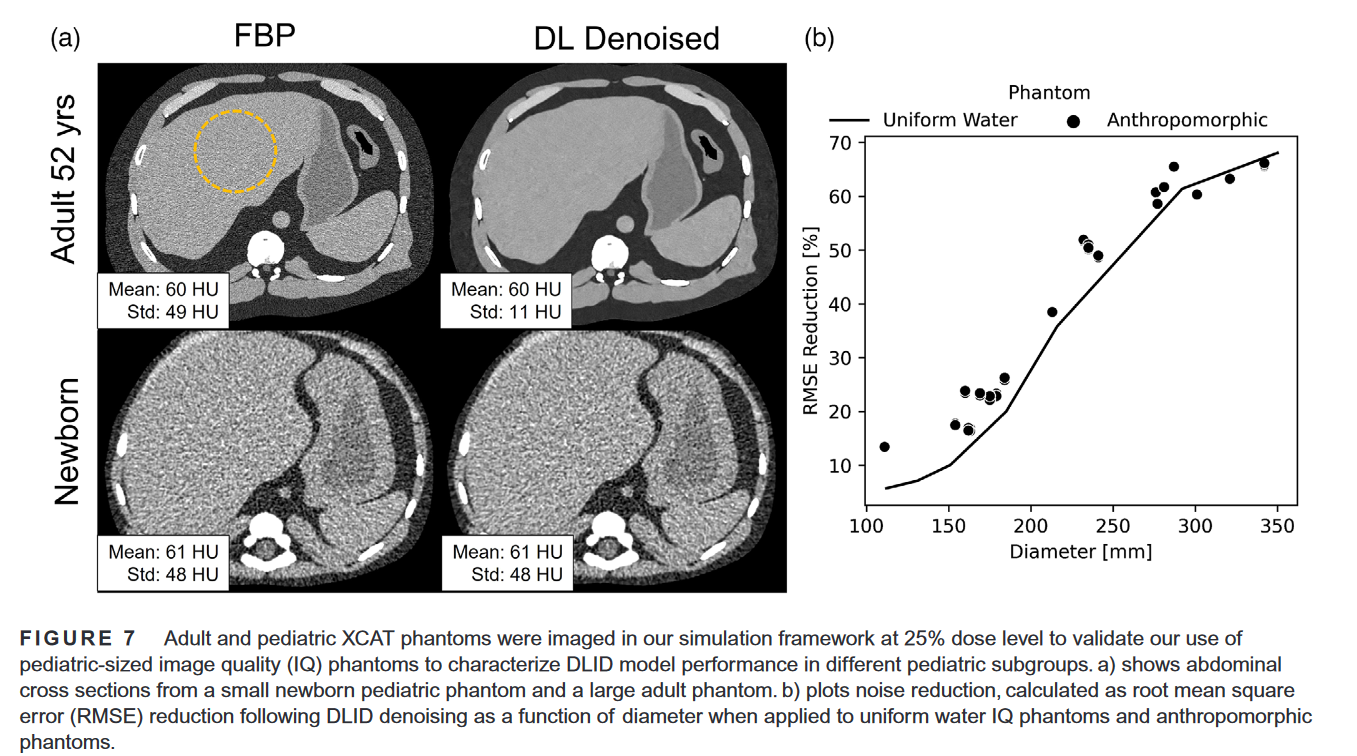

In [ ]:
import seaborn as sns

In [ ]:
recons = order_recons(results.recon.unique())
sns.lineplot(data=results[(results['Dose [%]']==25) & (results['effective diameter (cm)'] != 20)], x='effective diameter (cm)', y='rmse', style='phantom', hue='recon', hue_order=recons) 

In [ ]:
sns.lineplot(data=results[(results['Dose [%]']==25) & (results['effective diameter (cm)'] != 20) & (results['recon'] != 'fbp')], x='effective diameter (cm)', y='rmse reduction [%]', style='phantom', hue='recon', hue_order=recons[1:]) 

In [ ]:
sns.lineplot(data=results[(results['Dose [%]']==25) & (results['effective diameter (cm)'] != 20)], x='effective diameter (cm)', y='noise std', style='phantom', hue='recon', hue_order=recons) 

In [ ]:
sns.lineplot(data=results[(results['Dose [%]']==25) & (results['effective diameter (cm)'] != 20)], x='effective diameter (cm)', y='noise reduction [%]', style='phantom', hue='recon', hue_order=recons[1:]) 

It was aliasing! this shows tha the anthropomorphic does track with uniform and that augmentation does help the smallest patients in terms of RMSE reduction as well

In [ ]:
patient = results[(results.phantom == 'anthropomorphic') & (results.recon != 'fbp') ].sort_values(by='rmse reduction [%]').iloc[0]
print(patient)
plt.figure(dpi=300)
ctshow(load_mhd(anthro_dir / patient.file)[0])

In [ ]:
patient = results[(results.phantom == 'anthropomorphic') & (results.recon != 'fbp') & (results['Dose [%]'] == 25)].sort_values(by='rmse reduction [%]').iloc[0]
print(patient)
img = load_mhd(anthro_dir / patient.file)[0] 
gt = load_mhd(anthro_dir / get_ground_truth(patient.file)) - 1000
plt.figure(dpi=300)
ctshow(np.concatenate([gt, img], axis=1))

In [ ]:
plt.figure(dpi=300)
ctshow(img-gt)
plt.colorbar()

In [ ]:
patient = results[(results.phantom == 'anthropomorphic') & (results.recon != 'fbp') & (results['Dose [%]'] == 25)].sort_values(by='rmse reduction [%]').iloc[-1]
print(patient)
img = load_mhd(anthro_dir / patient.file)[0] 
gt = load_mhd(anthro_dir / get_ground_truth(patient.file)) - 1000
plt.figure(dpi=300)
ctshow(np.concatenate([gt, img], axis=1))

In [ ]:
plt.figure(dpi=300)
ctshow(img-gt)
plt.colorbar()

**Why is it that infants have greater RMSE reduction than adults? This is contrary to the previous paper...**

ALIASING?? Could that be it, but im using the same phantoms (in the previous paper I used the *true* phantom - free of aliasing as the truth, not the noiseless one), trying using true.mhd rather than noise free 

Yes it was aliasing, the one mystery remaining is why anthro slightly overperformed in the paper and now slightly under performs, this could be a noise thing or a definition thing but its not as big of a deal

In [ ]:
plt.figure(dpi=300)
make_montage(anthro_meta, diameters = [11.1, 34.2], phantom = 'anthropomorphic', roi_center=(220, 170), roi_diameter=0.2, wwwl=(200, 100))

In [ ]:
sns.lineplot(data=results[(results['Dose [%]']==25) &
                          (results['effective diameter (cm)'] != 20) &
                          (results['recon'] != 'fbp')], x='effective diameter (cm)', y='rmse reduction [%]', style='phantom', hue='recon', hue_order=recons[1:]) 

This basically replicates Fig 7 from Nelson 2023, but now with the augmentation in place. Can also show in terms of noise reduction which might be more compelling too

In [ ]:
import sys
import os
import torch
sys.path.append('../../denoising')
from networks import RED_CNN

In [ ]:
def load_model(save_path, iter_=13000, multi_gpu=False):
    REDCNN = RED_CNN()
    f = os.path.join(save_path, 'REDCNN_{}iter.ckpt'.format(iter_))
    if multi_gpu:
        state_d = OrderedDict()
        for k, v in torch.load(f):
            n = k[7:]
            state_d[n] = v
        REDCNN.load_state_dict(state_d)
        return REDCNN
    else:
        REDCNN.load_state_dict(torch.load(f))
        return REDCNN

cnn_denoiser = load_model('../../denoising/models/redcnn')
cnn_denoiser_augmented = load_model('../../denoising/models/redcnn_augmented')

## Bonus: Noise Reduction in Adult Patient Images
From Held out low dose grand challenge dataset. Same clinical site and scanner as training set but different patients.

In [ ]:
from collections import OrderedDict


def load_model(save_path, iter_=13000, multi_gpu=False):
    REDCNN = RED_CNN()
    f = os.path.join(save_path, 'REDCNN_{}iter.ckpt'.format(iter_))
    if multi_gpu:
        state_d = OrderedDict()
        for k, v in torch.load(f):
            n = k[7:]
            state_d[n] = v
        REDCNN.load_state_dict(state_d)
        return REDCNN
    else:
        REDCNN.load_state_dict(torch.load(f))
        return REDCNN

base_denoising_model  = load_model('../../denoising/models/redcnn')
aug_denoising_model = load_model('../../denoising/models/redcnn_augmented')

In [ ]:
test_input = np.load('../../data/Denoising_Data/test_input.npy').squeeze()
test_target = np.load('../../data/Denoising_Data/test_target.npy').squeeze()

nexample = 2
base_CNNout = base_denoising_model.predict(test_input[:, None, ...], batch_size=1).squeeze()
aug_CNNout = aug_denoising_model.predict(test_input[:, None, ...], batch_size=1).squeeze()

In [ ]:
plt.figure(figsize=(16, 8), tight_layout=True)

plt.subplot(2, 2, 1)
plt.title('Low Dose Input', fontsize=16)
ctshow(test_input[3, 110:-110, 50:-50])

plt.subplot(2, 2, 2)
plt.title('Hi Dose Input', fontsize=16)
ctshow(test_target[3, 110:-110, 50:-50])

plt.subplot(2, 2, 3)
plt.title('Base Denoiser', fontsize=16)
ctshow(base_CNNout[3, 110:-110, 50:-50])

plt.subplot(2, 2, 4)
plt.title('Denoiser with Augmentation', fontsize=16)
ctshow(aug_CNNout[3, 110:-110, 50:-50])
plt.savefig(f'test_patient.png', dpi=600, bbox_inches='tight')

In [ ]:
import pydicom

ld_dir = Path('/gpfs_projects/brandon.nelson/Mayo_LDGC/images/L506/quarter_3mm/')
fd_dir = Path('/gpfs_projects/brandon.nelson/Mayo_LDGC/images/L506/full_3mm/')
adult_ld_dcm_files = sorted(list(ld_dir.glob('*.IMA')))
adult_fd_dcm_files = sorted(list(fd_dir.glob('*.IMA')))

In [ ]:
adult_ld_dcm_files[:5], adult_fd_dcm_files[:5]

In [ ]:
import SimpleITK as sitk
def load_dcm_img(dcm_file):
    if isinstance(dcm_file, sitk.Image): return sitk.GetArrayFromImage(dcm_file)
    dcm = pydicom.read_file(dcm_file)
    return dcm.pixel_array + float(dcm.RescaleIntercept)

In [ ]:
idx = 30
ld = load_dcm_img(adult_ld_dcm_files[idx])
rd = load_dcm_img(adult_fd_dcm_files[idx])
ctshow(ld)

In [ ]:
denoised = cnn_denoiser.predict(ld).squeeze()

In [ ]:
ctshow(denoised)

In [ ]:
augmented = cnn_denoiser_augmented.predict(ld).squeeze()

In [ ]:
ctshow(augmented)

In [ ]:
plt.figure(dpi=300)
ctshow(np.concatenate([np.concatenate([ld, rd], axis=1),
                      np.concatenate([denoised, augmented], axis=1)], axis=0))

In [ ]:
plt.figure(dpi=300)
ctshow(np.concatenate([ld-rd, ld-denoised, ld-augmented],axis=1), (200, 0))

In [ ]:
ctshow(np.concatenate([rd - ld, rd-denoised, rd-augmented],axis=1), (200, 0))

In [ ]:
rmses = {v: rmse(k, rd) for (k, v) in zip([ld, denoised, augmented], ['low dose', 'redcnn', 'redcnn-aug'])}
rmses

In [ ]:
adult_fd_images = np.array([load_dcm_img(o) for o in sorted(adult_fd_dcm_files)])
adult_ld_images = np.array([load_dcm_img(o) for o in sorted(adult_ld_dcm_files)])
adult_fd_images.shape, adult_ld_images.shape

In [ ]:
cnn_denoiser.to('cuda')
cnn_denoiser.predict(adult_ld_images[:,None,:,:], device='cuda', batch_size=32);

In [ ]:
rmse(adult_fd_images, adult_ld_images)

In [ ]:
batch_size=32
device = 'cuda'

series_rmse = ['low dose', 'redcnn', 'redcnn-aug']
res = np.zeros((len(series_rmse), len(adult_ld_dcm_files)))
adult_fd_images = np.array([load_dcm_img(o) for o in sorted(adult_fd_dcm_files)])
adult_ld_images = np.array([load_dcm_img(o) for o in sorted(adult_ld_dcm_files)])

for d_idx, (denoiser, name) in enumerate(zip([None, cnn_denoiser, cnn_denoiser_augmented], series_rmse)):
    if denoiser is None:
       res[0, :] = list(map(lambda x, y: rmse(x, y), adult_ld_images, adult_fd_images))
    else:
        denoiser.to(device)
        denoised = denoiser.predict(adult_ld_images[:, None,:,:], device=device, batch_size=batch_size).squeeze()
        res[d_idx, :] = list(map(lambda x, y: rmse(x, y), denoised, adult_fd_images))

In [ ]:
rmse_df = pd.DataFrame(data=res.T, columns = series_rmse)
rmse_df['full dose file'] = str(adult_fd_dcm_files)
rmse_df['quarter dose file'] = str(adult_ld_dcm_files)
rmse_df

In [ ]:
sns.violinplot(data=rmse_df)
plt.ylabel('RMSE')
plt.title('Adult Real Patient Test Data from Mayo')

In [ ]:
sns.scatterplot(data=rmse_df,x='low dose', y='redcnn', label='redcnn')
sns.scatterplot(data=rmse_df,x='low dose', y='redcnn-aug', label='redcnn aug')
plt.ylabel('RMSE')
plt.legend()

The fact that the augmented model underperforms the original model when tested on *adult* data is unsurprising, our hypothesis is that it would act as a regularizer and yield more consistent performance in *smaller* patients, need to explore this next

### [Mayo Clinic Low-dose CT image and projection dataset](https://onlinelibrary.wiley.com/doi/abs/10.1002/mp.14594)

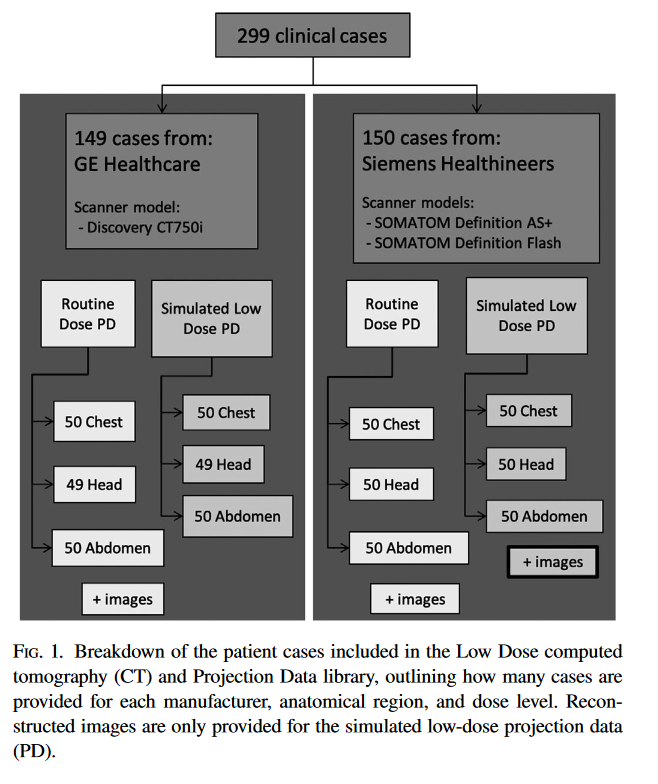

In [ ]:
ldct_dir = Path('/gpfs_projects/common_data/DLIR/TCIA/manifest-1643214718297')
meta = pd.read_csv(ldct_dir/'metadata.csv', index_col=0)
meta.head()

In [ ]:
patients = meta['Subject ID'].unique()
len(patients)

In [ ]:
subject_id = patients[0]
dose = 'Full' # 'Full' or 'Low'
assert(dose in ['Full', 'Low'])
n_images = meta[(meta['Subject ID']==subject_id) & (meta['Series Description']==f'{dose} Dose Images')]['Number of Images'].item()
image_dcms = sorted(list(Path(ldct_dir / meta[(meta['Subject ID']==subject_id) & (meta['Series Description']==f'{dose} Dose Images')]['File Location'].item().strip('./')).glob('*')))
assert(len(image_dcms) == n_images)

In [ ]:
ctshow(load_dcm_img(image_dcms[2]))

**Need to think about what this notebook adds and if its different from `patient images.ipynb`, the main message is denoising efficiency and thus belongs in that notebook**

## Conclusions

This can have the merged uniform and anthro rmse reduction plot like in Nelson et al 2023